In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
assignments = pd.read_csv("NM VTD Block Assign FINAL 20210812.csv")

In [3]:
assignments["block"] = assignments["Block"].astype(str)
assignments["vtdgeoid"] = assignments["VTDID"].astype(str)

In [4]:
census_vtd = gpd.read_file("/home/max/git/census-process/final/nm/nm_vtd.shp")
census_blocks = gpd.read_file("/home/max/git/census-process/final/nm/nm_block.shp")

## New Mexico plausibility checks

In [5]:
# census_blocks
assignments

,Block,VTDID,State,County,VTD,VTD Name,block,vtdgeoid
0,350010001071000,35001000564,35,1,564,564,350010001071000,35001000564
1,350010001071001,35001000564,35,1,564,564,350010001071001,35001000564
2,350010001071002,35001000564,35,1,564,564,350010001071002,35001000564
3,350010001071003,35001000564,35,1,564,564,350010001071003,35001000564
4,350010001071004,35001000564,35,1,564,564,350010001071004,35001000564
...,...,...,...,...,...,...,...,...
107210,350619803001004,35061000041,35,61,41,41,350619803001004,35061000041
107211,350619803001005,35061000041,35,61,41,41,350619803001005,35061000041
107212,350619803001006,35061000041,35,61,41,41,350619803001006,35061000041
107213,350619803001007,35061000041,35,61,41,41,350619803001007,35061000041


In [6]:
assert len(set(assignments["block"]) - set(census_blocks["GEOID20"])) == 0

In [7]:
assert len(set(census_blocks["GEOID20"]) - set(assignments["block"])) == 0

In [8]:
len(set(assignments["vtdgeoid"]) - set(census_vtd["GEOID20"])) # diff is not zero

194

In [9]:
len(set(census_vtd["GEOID20"]) - set(assignments["vtdgeoid"])) # diff is not zero

20

In [10]:
len(set(census_vtd["GEOID20"]))

1977

In [11]:
assert not assignments["vtdgeoid"].astype(int).isna().any()

In [12]:
(census_blocks["GEOCODE"] == census_blocks["GEOID20"]).all()

True

Conclusions:
- it appears that the state provided block assignment file totally covers the state and is valid
- the state-provided block assignment file is *not* equivalent to the Census VTD assignments
- we should produce an updated precincts file for NM

## Creating an updated NM precincts file

In [13]:
census_blocks = census_blocks.merge(assignments, left_on="GEOCODE", right_on="block")

In [14]:
census_blocks.columns

Index(['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'BLOCKCE20', 'GEOID20',
       'NAME20', 'MTFCC20', 'UR20', 'UACE20', 'UATYPE20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'TOTPOP', 'WHITE',
       'BLACK', 'AMIN', 'ASIAN', 'NHPI', 'OTHER', '2MORE', 'HISP', 'VAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'HVAP', 'LOGRECNO', 'GEOCODE', 'SUMLEV', 'geometry',
       'Block', 'VTDID', 'State', 'County', 'VTD', 'VTD Name', 'block',
       'vtdgeoid'],
      dtype='object')

In [30]:
aggregation_method = {}
for col in census_blocks.columns:
    if col.endswith("VAP") or str(col) in ["ASIAN", "BLACK", "WHITE", "TOTPOP", "AMIN", "NHPI", "OTHER", "2MORE", "HISP"]:
        print(col)
        aggregation_method[col] = "sum"
    elif col == "geometry":
        continue
    else:
        aggregation_method[col] = "first"

TOTPOP
WHITE
BLACK
AMIN
ASIAN
NHPI
OTHER
2MORE
HISP
VAP
WVAP
BVAP
AMINVAP
ASIANVAP
NHPIVAP
OTHERVAP
2MOREVAP
HVAP


In [31]:
type(census_blocks)

geopandas.geodataframe.GeoDataFrame

In [32]:
nm_precincts = census_blocks.dissolve("VTDID", aggregation_method)

In [33]:
del nm_precincts["VTDID"]

In [34]:
nm_precincts.to_file("nm_precincts.shp", index=True)

## Basic QA

<AxesSubplot:>

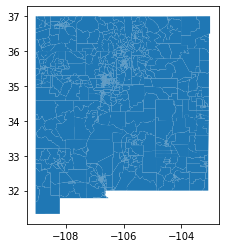

In [35]:
nm_precincts.plot()

In [37]:
assert len(nm_precincts) == len(set(assignments["VTDID"]))